<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import itertools
import patsy
import statsmodels.api as sm
import pylab
from collections import Counter
from scipy.stats import kendalltau
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, Lasso, LassoCV, RidgeCV, ElasticNetCV, ElasticNet, Ridge, RidgeClassifierCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from imblearn.datasets import make_imbalance
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier, BalanceCascade
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, NearMiss, NeighbourhoodCleaningRule
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
random.seed(42)
np_seed = np.random.RandomState(42)

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be remo

### Derived Variables from Part 1

This section contains relevant codes which are required for the analysis of the minority class.

In [2]:
house = pd.read_csv('./housing.csv')
res_mask = house['MSZoning'] != 'C (all)'
house_res = house[res_mask]
house_res.reset_index(inplace=True)
house_res.drop(['index'], axis='columns', inplace=True)
date_cols = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
house_res['LotFrontage'] = house_res['LotFrontage'].fillna(0.0)
house_res['MasVnrArea'] = house_res['MasVnrArea'].fillna(0.0)
gyb_no_nan = house_res['GarageYrBlt'].dropna(how='all')

def fit_garagebltyr(pdSr):
    """ Fill a reasonable garage built-year for those without.
    Year of garage built cannot be earlier than the property built """   
    for idx, row in enumerate(pdSr):
        if pdSr[idx] == 99999:
            gen_year = np.round(random.choice(np.random.RandomState(42).uniform(1990, 2010, size=10000)))            
            while house_res.ix[idx, 'YearBuilt'] > gen_year:
                gen_year = np.round(random.choice(np.random.RandomState(42).uniform(1990, 2010, size=10000)))
            pdSr[idx] = gen_year # This is a procedural function, thus there were no return values

house_res['GarageYrBlt'] = house_res['GarageYrBlt'].fillna(99999)
fit_garagebltyr(house_res['GarageYrBlt'])
gyb_no_nan = house_res['GarageYrBlt']
house_res['Electrical'] = house_res['Electrical'].fillna('SBrkr')

fill_dict = {'Alley': 'NoAll',
            'MasVnrType': 'CBlock', # Replace from 'NoVnr' to 'CBlock'
            'BsmtQual': 'NoBsmt',
            'BsmtCond': 'NoBsmt',
            'BsmtExposure': 'NoBsmt',
            'BsmtFinType1': 'NoBsmt',
            'BsmtFinType2': 'NoBsmt',
            'FireplaceQu': 'NoFir',
            'GarageType': 'NoGar',
            'GarageFinish': 'NoGar',
            'GarageQual': 'NoGar',
            'GarageCond': 'NoGar',
            'PoolQC': 'NoPool',
            'Fence': 'NoFen',
            'MiscFeature': 'NoMisF'}
fill_cols = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

for column in fill_cols:
    house_res[column] = house_res[column].fillna(fill_dict[column])
    
int_float_ft = ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1',
                'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
                'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
                'PoolArea', 'MiscVal', 'SalePrice']
var_ft_c = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
          'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating',
          'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish',
          'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']

var_ft_unc = ['MiscVal', 'SaleType', 'SaleCondition', 'SalePrice']
fx_ft = [feat for feat in house_res.columns
          if (feat not in var_ft_c) and (feat not in var_ft_unc)]
fx_ft = fx_ft[1:]
cat_ft = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
         'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
         'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
         'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
         'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
         'MiscFeature', 'SaleType', 'SaleCondition', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

onehot_df = pd.DataFrame()
for feat in cat_ft:
    onehot_df = pd.concat([onehot_df, pd.get_dummies(house_res[feat], prefix=feat, prefix_sep='_', drop_first=False)],
                          axis='columns')

resident = pd.concat([house_res, onehot_df], axis='columns')
resident['MSSubClass'] = resident['MSSubClass'].apply(lambda x: str(x))
fx_and_cat = list((set(fx_ft).intersection(set(cat_ft))).difference(set(date_cols)))
fxcat_lessneigh = [elem for elem in fx_and_cat if elem != 'Neighborhood']
fx_date_and_cat = list((set(fx_ft).intersection(set(cat_ft))).intersection(set(date_cols)))
fx_and_noncat = list(set(fx_ft).difference(set(cat_ft)))

resident['TotalSF'] = resident['GrLivArea'].add(resident['TotalBsmtSF'])
pos_nonlin_dvars = ['HalfBath', 'BsmtFullBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars']

fx_var_reg_all = ['BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtQual_Fa', 'BsmtQual_NoBsmt',
              'BsmtExposure_Gd', 'BsmtExposure_Av', 'BsmtExposure_Mn', 'BsmtExposure_No', 'BsmtExposure_NoBsmt',
              'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_50',
              'GarageType_Attchd', 'GarageType_Detchd', 
              'MSZoning_RM', 'MSZoning_RL', 
              'LotConfig_Inside', 'LotConfig_Corner', 
              'LotShape_IR1', 'LotShape_Reg', 
              'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
              'HouseStyle_1.5Fin', 'HouseStyle_1Story', 'HouseStyle_2Story',
              'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel',
              'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide',
              'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW',
              'Neighborhood_Edwards', 'Neighborhood_Gilbert',
              'MasVnrArea', 'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'GrLivArea',
              'FullBath', 'BsmtHalfBath', '2ndFlrSF', 'BsmtFullBath', 'OpenPorchSF', 'GarageArea', 'WoodDeckSF',
              'TotalBsmtSF'
             ]
fx_var_reg_adjst = ['BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtQual_Fa',
              'BsmtExposure_Gd', 'BsmtExposure_Av', 'BsmtExposure_Mn', 'BsmtExposure_No',
              'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_50',
              'GarageType_Attchd', 'GarageType_Detchd', 
              'MSZoning_RM', 'MSZoning_RL', 
              'LotConfig_Inside', 'LotConfig_Corner', 
              'LotShape_IR1', 'LotShape_Reg', 
              'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
              'HouseStyle_15Fin', 'HouseStyle_1Story', 'HouseStyle_2Story',
              'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel',
              'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide',
              'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW',
              'Neighborhood_Edwards', 'Neighborhood_Gilbert',
              'MasVnrArea', 'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'GrLivArea',
              'FullBath', 'BsmtHalfBath', 'Flr2ndSF', 'BsmtFullBath', 'OpenPorchSF', 'GarageArea', 'WoodDeckSF',
              'TotalBsmtSF'
             ]

resident.rename(index=str, columns={'HouseStyle_1.5Fin': 'HouseStyle_15Fin'}, inplace=True)
resident.rename(index=str, columns={'2ndFlrSF': 'Flr2ndSF'}, inplace=True)

final_fx = ['BsmtQual_Ex', 'BsmtQual_TA', 'BsmtQual_Fa',
            'BsmtExposure_Gd', 'BsmtExposure_Av', 'BsmtExposure_Mn', 'BsmtExposure_No',
            'MSSubClass_20', 'MSSubClass_60', 'MSSubClass_50',
            'GarageType_Attchd',
            'MSZoning_RL',
            'LotConfig_Inside',
            'LotShape_Reg',
            'Foundation_BrkTil', 'Foundation_PConc',
            'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel',
            'Neighborhood_Somerst', 'Neighborhood_NWAmes', 'Neighborhood_OldTown', 'Neighborhood_BrkSide',
            'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes', 'Neighborhood_SawyerW',
            'Neighborhood_Edwards', 'Neighborhood_Gilbert',
            'MasVnrArea', 'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'LotFrontage', 'LotArea', 'BedroomAbvGr', 'GrLivArea',
            'FullBath', 'BsmtHalfBath', 'BsmtFullBath', 'OpenPorchSF', 'GarageArea', 'WoodDeckSF', 'TotalBsmtSF'
             ]
final_fx2 = ['BsmtQual_Ex', 'BsmtQual_Fa',
            'BsmtExposure_Gd',
            'MSSubClass_20',
            'MSZoning_RL',
            'Foundation_PConc',
            'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_Mitchel', 'Neighborhood_Somerst',
            'Neighborhood_NWAmes', 'Neighborhood_Sawyer', 'Neighborhood_NridgHt', 'Neighborhood_NAmes',
            'Neighborhood_Edwards',
            'HalfBath', 'KitchenAbvGr', 'Fireplaces', 'BedroomAbvGr', 'GrLivArea',
            'FullBath', 'BsmtFullBath', 'GarageArea'
             ]

var_ft_c_cat = list(set(var_ft_c).intersection(set(cat_ft)))
var_ft_c_noncat = list(set(var_ft_c).difference(set(cat_ft)))

resident.rename(columns={'Exterior2nd_Wd Shng': 'Exterior2nd_WdShng', 'Exterior2nd_Wd Sdng': 'Exterior2nd_WdSdng'}, 
                index=str, inplace=True)
resident.rename(columns={'Exterior1st_Wd Sdng': 'Exterior1st_WdSdng'}, index=str, inplace=True)

var_ft_reg_all = ['Fence_NoFen', 'Fence_MnPrv',
                 'ExterCond_TA', 'ExterCond_Gd',
                 'KitchenQual_TA', 'KitchenQual_Gd',
                 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageFinish_Fin',
                 'RoofStyle_Gable', 'RoofStyle_Hip',
                 'HeatingQC_Ex', 'HeatingQC_Gd', 'HeatingQC_TA',
                 'FireplaceQu_NoFir', 'FireplaceQu_TA', 'FireplaceQu_Gd',
                 'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
                 'BsmtFinType1_GLQ', 'BsmtFinType1_ALQ', 'BsmtFinType1_Unf', 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ',
                 'Exterior2nd_VinylSd', 'Exterior2nd_MetalSd', 'Exterior2nd_WdShng', 'Exterior2nd_HdBoard',
                 'Exterior2nd_Plywood', 'Exterior2nd_WdSdng',
                 'Exterior1st_VinylSd', 'Exterior1st_MetalSd', 'Exterior1st_WdSdng',
                 'Exterior1st_HdBoard', 'Exterior1st_Plywood',
                 'ExterQual_TA', 'ExterQual_Gd',
                 'BsmtFinSF1', 'OverallQual', 'BsmtUnfSF']
var_ft_reg_adjst = var_ft_reg_all

var_ft_c_1hot = pd.DataFrame()
interim_undsc = [feat+'_' if feat not in var_ft_c_noncat else feat for feat in var_ft_c]
for feat in interim_undsc:
    var_ft_c_1hot = pd.concat([var_ft_c_1hot, 
                               resident[resident.columns[pd.Series(resident.columns).str.startswith(feat)]]],
                              axis='columns')

final_var = ['Fence_NoFen',
             'ExterCond_TA', 'ExterCond_Gd',
             'KitchenQual_TA',
             'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageFinish_Fin',
             'RoofStyle_Gable',
             'HeatingQC_Ex', 'HeatingQC_Gd', 'HeatingQC_TA',
             'FireplaceQu_NoFir', 'FireplaceQu_TA', 'FireplaceQu_Gd',
             'MasVnrType_None', 'MasVnrType_Stone',
             'BsmtFinType1_GLQ', 'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ',
             'Exterior2nd_VinylSd', 'Exterior2nd_WdShng', 'Exterior2nd_WdSdng',
             'Exterior1st_MetalSd', 'Exterior1st_HdBoard', 'Exterior1st_Plywood',
             'ExterQual_TA',
             'BsmtFinSF1', 'OverallQual', 'BsmtUnfSF'
            ]
final_var2 = ['ExterCond_Gd', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageFinish_Fin', 'RoofStyle_Gable',
              'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ', 'OverallQual']
final_var3 = ['ExterCond_Gd', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageFinish_Fin',
              'BsmtFinType1_ALQ', 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ', 'OverallQual']

enet_var_ft = ['OverallQual', 'OverallCond', 'RoofMatl_ClyTile', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace',
               'Exterior2nd_BrkFace', 'ExterQual_Ex', 'BsmtFinSF1', 'LowQualFinSF', 'KitchenQual_Ex', 'Functional_Sev',
               'Functional_Typ', 'FireplaceQu_NoFir', 'GarageFinish_Fin', 'GarageFinish_NoGar', 'GarageQual_Ex',
               'GarageQual_NoGar', 'PoolQC_Ex', 'PoolQC_NoPool']
oldsch_var_ft = ['ExterCond_Gd', 'GarageFinish_RFn', 'GarageFinish_Unf', 'GarageFinish_Fin', 'BsmtFinType1_ALQ',
                 'BsmtFinType1_Rec', 'BsmtFinType1_BLQ', 'OverallQual']

full_reg_ft = final_fx2 + enet_var_ft
final_regr_ft = [feat for feat in full_reg_ft if feat != 'FireplaceQu_NoFir']
final_regr_ft_2 = [feat for feat in final_regr_ft if feat not in ('HalfBath', 'Exterior2nd_BrkFace', 'GarageQual_Ex', 'PoolQC_Ex')]
final_regr_ft_3 = [feat for feat in final_regr_ft_2 if feat not in ('BedroomAbvGr', 'BsmtFullBath', 'PoolQC_NoPool')]

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [3]:
# A:

#### Preliminary

Before resampling is done on the imbalanced data, it is best to perform EDA on the features against 'SaleCondition'
- Provides us with how the features are distributed
    - In what manner are the features imbalanced (if any)
- Defining what should be classified as an outlier (if any), certain resampling methods may not be appropriate
    - i.e. SMOTE over-sampling is inappropriate for high dimensionality-based data
- Perform feature selection that best relates to 'SaleCondition'
- Perform PCA visualisations to observe cluster patterns for sampling choice decision-making

In [4]:
### Pre-processing dataframe and validations ###

# Extract out all categorical features' original columns from 'resident' to preserve their 1-hot encoded columns only
full_feat_df = resident.drop(columns=cat_ft)

# Drop 'Id' and 1hot-encoded 'SaleCondition'
full_feat_df = full_feat_df.drop(columns=['Id', 
                                         'SaleCondition_Abnorml', 
                                         'SaleCondition_AdjLand', 
                                         'SaleCondition_Family', 
                                         'SaleCondition_Normal', 
                                         'SaleCondition_Partial', 
                                         'SaleCondition_Alloca'])

# Rename column names in case statsmodels/patsy gets used
    # Unable to parse variables starting with numerals and or contain incompatible non-alphanumerals (i.e. punctuations)
full_feat_df.rename(columns={'3SsnPorch':'Ssn3Porch', 
                            'HouseStyle_1.5Unf':'HouseStyle_15Unf', 
                            'HouseStyle_2.5Fin':'HouseStyle_25Fin', 
                            'HouseStyle_2.5Unf':'HouseStyle_25Unf',
                            '1stFlrSF':'Flr1stSF'}, inplace=True)

# Print '.info' on 'full_feat_df' - Brief check for improperly named columns
pd.set_option('max_info_rows', 800)
pd.set_option('max_info_columns', 800)
print(full_feat_df.info())

# Redefine non-categorical variables
non_cat_feat = [feat for feat in full_feat_df.columns if full_feat_df[feat].dtype != 'uint8']
print(non_cat_feat)

<class 'pandas.core.frame.DataFrame'>
Index: 1450 entries, 0 to 1449
Data columns (total 593 columns):
LotFrontage             float64
LotArea                 int64
OverallQual             int64
OverallCond             int64
MasVnrArea              float64
BsmtFinSF1              int64
BsmtFinSF2              int64
BsmtUnfSF               int64
TotalBsmtSF             int64
Flr1stSF                int64
Flr2ndSF                int64
LowQualFinSF            int64
GrLivArea               int64
BsmtFullBath            int64
BsmtHalfBath            int64
FullBath                int64
HalfBath                int64
BedroomAbvGr            int64
KitchenAbvGr            int64
TotRmsAbvGrd            int64
Fireplaces              int64
GarageCars              int64
GarageArea              int64
WoodDeckSF              int64
OpenPorchSF             int64
EnclosedPorch           int64
Ssn3Porch               int64
ScreenPorch             int64
PoolArea                int64
MiscVal                

In [5]:
### Pre-processing dataframe and validations ###
    
# Create new copy of 'resident' - full data
resident_3 = resident    

# Convert all non-abnormal values as 'Non_Abnml'
resident_3['SaleCondition'] = resident_3['SaleCondition'].map(lambda x: 'Non_Abnml' if x != 'Abnorml' else x)

# 1-hot encode 'SaleCondition'
salecond_1hot = resident_3['SaleCondition'].map(lambda x: 1 if x=='Abnorml' else 0)
    # Could have done this directly during the first mapping

In [6]:
### Feature Selection - LassoCV ###
# Perform LassoCV to obtain relevant variables that associates with 'SaleCondition'
# Extract relevant features out and make a PCA plot again to observe for changes in clustering

ss = StandardScaler()
X_lasso = full_feat_df.as_matrix()
y_lasso = resident_3['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0).as_matrix()
Xs_lasso = ss.fit_transform(X_lasso)

X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(Xs_lasso, y_lasso, random_state=42, test_size=0.30)
    
lasso_cv = LassoCV(random_state=42, cv=10, verbose=True, n_jobs=-1)

lasso_fit = lasso_cv.fit(X_train_lasso, y_train_lasso)
prediction = lasso_fit.predict(X_test_lasso)
score = lasso_fit.score(X_test_lasso, y_test_lasso)

print('Score: {}'.format(score))

........................................................................................................................................................................................................................................................................................................C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.........................................................................................................................................................................................................................................................................................................................................................................................................................

Score: 0.09573988789545707


.[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   54.8s finished


#### LassoCV results

However the score is exceptionally poor, this could be the case that the features are poorly correlated with 'SaleCondition'.

Perhaps looking at the correlations may provide a more useful case for us to select features that best associate with 'SaleCondition'.

C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda2\envs\tensorflow\lib\site-packages\numpy\lib\function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Mean 0.0011909673611362815, std 0.04254114117204968, mean+2sd 0.08627324970523563, mean-2sd -0.08389131498296308
20 features selected out of 593 features to predict abnormal sales.


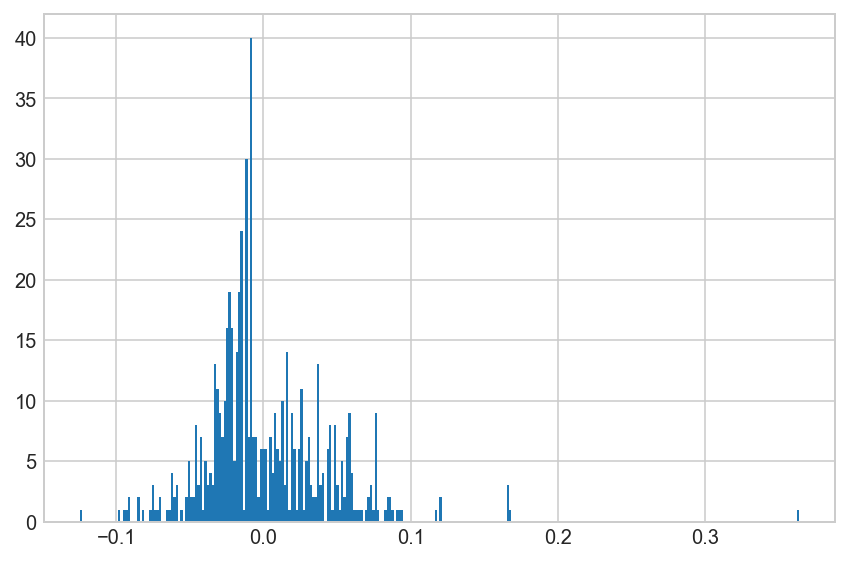

In [7]:
### Feature Selection - Correlation Test ###

# Create correlation dataframe of 'SaleCondition' against other features
corr_df = pd.concat([resident_3[['SaleCondition']], full_feat_df], axis='columns')
X_corr = corr_df.drop(columns=['SaleCondition'])
y_corr = resident_3['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0)

# Train-test split data, observe correlations from the training data only
X_train_corr, X_test_corr, y_train_corr, y_test_corr = train_test_split(X_corr.as_matrix(), y_corr.as_matrix(), random_state=42, test_size=0.30)
X_train_corr = pd.DataFrame(X_train_corr, columns=X_corr.columns)
y_train_corr = pd.DataFrame(y_train_corr, columns=['SaleCondition'])

# Create feature-correlation pairs for visualisation
corrs = [(feat, np.corrcoef(X_train_corr[feat].as_matrix(), y_train_corr['SaleCondition'].as_matrix())[0,1])
        for feat in X_train_corr.columns]

# Plot correlation distribution of features against 'SaleCondition'
corr_array = [corr[1] for corr in corrs]
    # Extract correlation values only
    # 'NaN's were generated; COV(x1, x2)==0/sd==0; Reference: https://github.com/numpy/numpy/issues/5080
    # Recall that certain categorical features were highly imbalanced and therefore a train-test split may result in
    # columns with 1 single unique value, a column of 0's against a column of 1's might cause this 'NaN'

# Remove 'NaN's using pd.DataFrame
corr_Xna_df = pd.DataFrame(np.array(corr_array), columns=['Correlations']).dropna(how='all')
    # Need to label the column, else matplotlib.pyplot will hang during plotting

_ = plt.hist(corr_Xna_df['Correlations'], bins=300); plt.tight_layout()
    # Most features are correlated near zero values

# Use features +/-2sd from the mean correlation value
print('Mean {}, std {}, mean+2sd {}, mean-2sd {}'.format(np.mean(corr_Xna_df['Correlations']), np.std(corr_Xna_df['Correlations']),
                                                      np.mean(corr_Xna_df['Correlations'])+2*np.std(corr_Xna_df['Correlations']),
                                                      np.mean(corr_Xna_df['Correlations'])-2*np.std(corr_Xna_df['Correlations'])))
# Computed mean, sd. of the correlations
corr_mu = np.mean(corr_Xna_df['Correlations'])
corr_sig = np.std(corr_Xna_df['Correlations'])

# Extract features +/-2sd from mean correlation
related2_salecond = [feat[0] for feat in corrs if feat[1] >= corr_mu+2*corr_sig or feat[1] <= corr_mu-2*corr_sig ]
print('{} features selected out of {} features to predict abnormal sales.'.format(len(related2_salecond), len(corrs)))

In [8]:
"""
This segment was commented out as it performs a correlation computation using the entire dataset rather than using only the
training set. 130 out of 593 features would have been selected. Visually, this does not improve the PCA visualisation much
and similar in the eventual scores as well, as shown in the classification report below:

[1: Abnormal, 0: Normal]

Confusion Matrix:  
 [[268 139]
 [  9  19]]
Classification Report 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.66      0.68      0.78      0.34      0.13       407
          1       0.12      0.68      0.66      0.20      0.34      0.11        28

avg / total       0.91      0.66      0.68      0.75      0.34      0.12       435

****************************************************************************************************************************
# Create feature-correlation pairs for visualisation
corrs = [(feat, np.corrcoef(full_feat_df[feat].as_matrix(), salecond_1hot.as_matrix())[0,1])
        for feat in full_feat_df.columns]

# Plot correlation distribution of features against 'SaleCondition'
corr_array = [corr[1] for corr in corrs]
    # Extract correlation values only
_ = plt.hist(corr_array, bins=300); plt.tight_layout()
    # Most features are correlated near zero values

# Use features +/-2sd from the mean correlation value
print('Mean {}, std {}, mean+2sd {}, mean-2sd {}'.format(np.mean(corr_array), np.std(corr_array),
                                                      np.mean(corr_array)+2*np.std(corr_array),
                                                      np.mean(corr_array)-2*np.std(corr_array)))

# Extract features +/-2sd from mean correlation
related2_salecond = [feat[0] for feat in corrs if feat[1] >= 0.04102243598032656 or feat[1] <= -0.03719135914274927 ]
print('{} features selected out of {} features to predict abnormal sales.'.format(len(related2_salecond), len(corrs)))
****************************************************************************************************************************
Note: Backend, there seems to be some randomisation error that causes the number of features selected to swing between
126-130 each time this segment was executed. The report was based on a 129 feature selected case. This randomisation error
has since been corrected in the main script.
"""
print()

#### Correlation Results

As expected, the correlations are extremely poor especially when they are centered around 0 value. Nonetheless, we shall use features that correlate with 'SaleCondition' within +/- 2 s.d. from the average value of the correlations.

explained variance ratio (first two components): [  9.99995065e-01   4.35525573e-06]


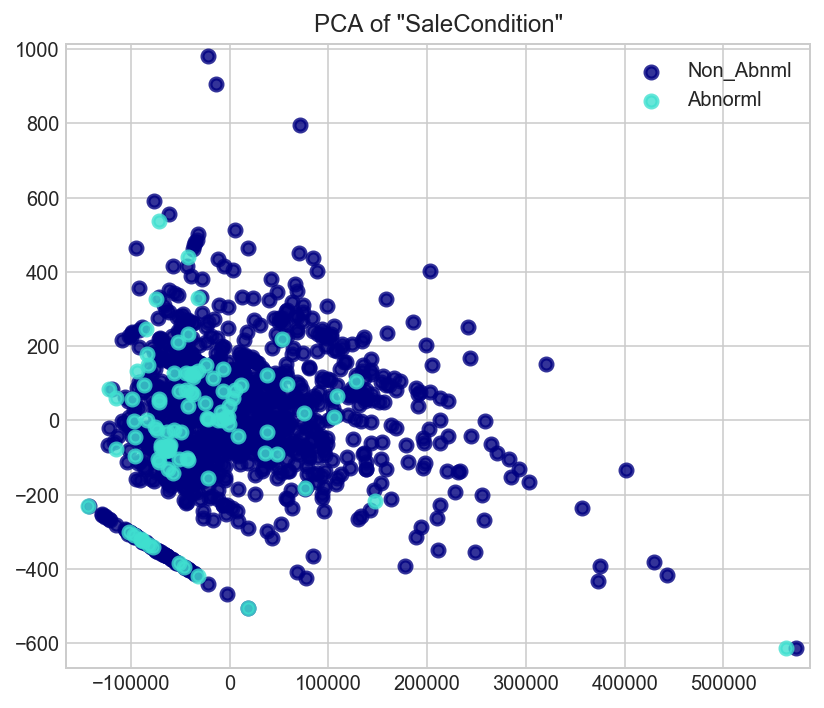

In [9]:
### Visualisation of 'SaleCondition' clusters - PCA ###
# References: http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html

# Make PCA plots of the entire dataset without any preprocessing to observe data
X_pca = full_feat_df[related2_salecond].as_matrix()
y_pca = resident['SaleCondition'].map(lambda x: 1 if x == 'Abnorml' else 0).as_matrix()
target_names = resident['SaleCondition'].unique()

pca = PCA(n_components=2)
X_r = pca.fit_transform(X_pca)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(6,5)); colors = ['navy', 'turquoise']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of "SaleCondition"')
plt.tight_layout(); plt.margins(0.02)

plt.show()

explained variance ratio (first two components): [  9.99995238e-01   4.19663113e-06]


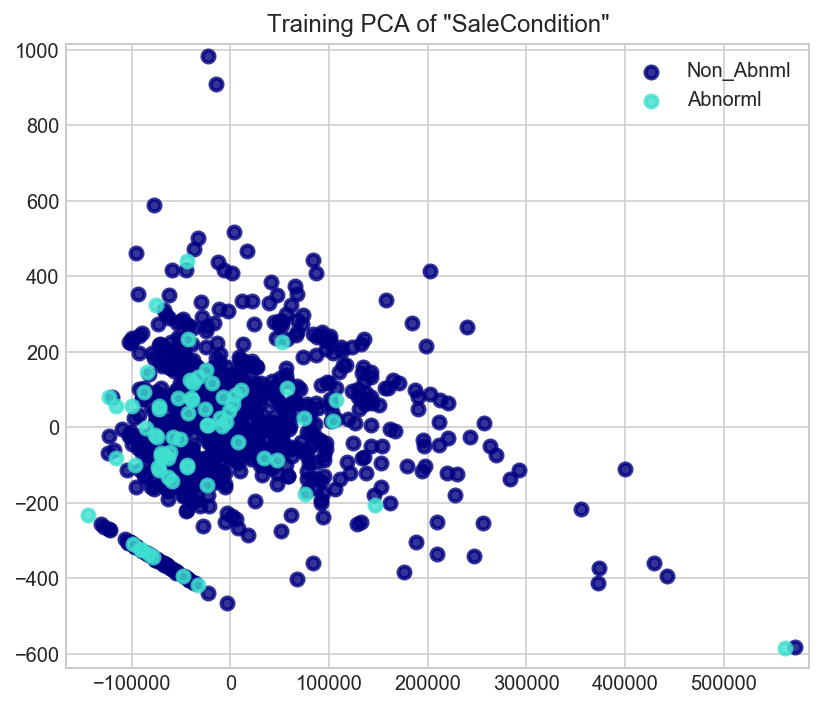

In [10]:
### Visualisation of 'SaleCondition' clusters - PCA ###

# Split into train test set and observe the PCA plot on training set only
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_pca, random_state=42, test_size=0.30)

pca = PCA(n_components=2)
X_r = pca.fit_transform(X_train)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(6,5)); colors = ['navy', 'turquoise']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Training PCA of "SaleCondition"')
plt.tight_layout(); plt.margins(0.02)

plt.show()

#### Strategy to improve clustering

The aim is to 'thin out' the density of the majority class without affecting its overall clustering pattern while 'darkening' the cluster pattern for the minority.

As a finishing step, we could explore the use of Tomek Links to remove or at least minimise the overlaps to make the boundaries of the clusters more distinct

Since the minority appears to be a subset of the majority class, maximising recall on the minority would definitely result in a poorer recall on the majority as those overlaps will be classified as the minority.

In [11]:
### List of imblearn classifiers/up-down sampling mehtods explored ###

# Down-sampling
tl = TomekLinks(ratio='all', random_state=42, n_jobs=-1)
enn = EditedNearestNeighbours(ratio='majority', random_state=42, n_neighbors=5) 
renn = RepeatedEditedNearestNeighbours(ratio='majority', n_neighbors=9, random_state=42, max_iter=666666)
ncl = NeighbourhoodCleaningRule(ratio='auto', n_neighbors=31, random_state=42)
nm = NearMiss(n_neighbors=9, ratio='majority', version=3, random_state=42)
adasyn = ADASYN(ratio='minority', random_state=42) 

# Up-sampling
smt = SMOTE(ratio='auto', random_state=42, kind='borderline1')
rand = RandomOverSampler(random_state=42, ratio='all')

# Combined-sampling
smotetl = SMOTETomek(random_state=42, tomek=tl, smote=smt)

# Classifiers
bc = BalanceCascade(random_state=42, ratio='not minority')
bbc = BalancedBaggingClassifier(random_state=42, n_estimators=600, ratio='all', replacement=True, oob_score=False, n_jobs=-1)

explained variance ratio (first two components), experimental: [  9.99995284e-01   4.10027495e-06]


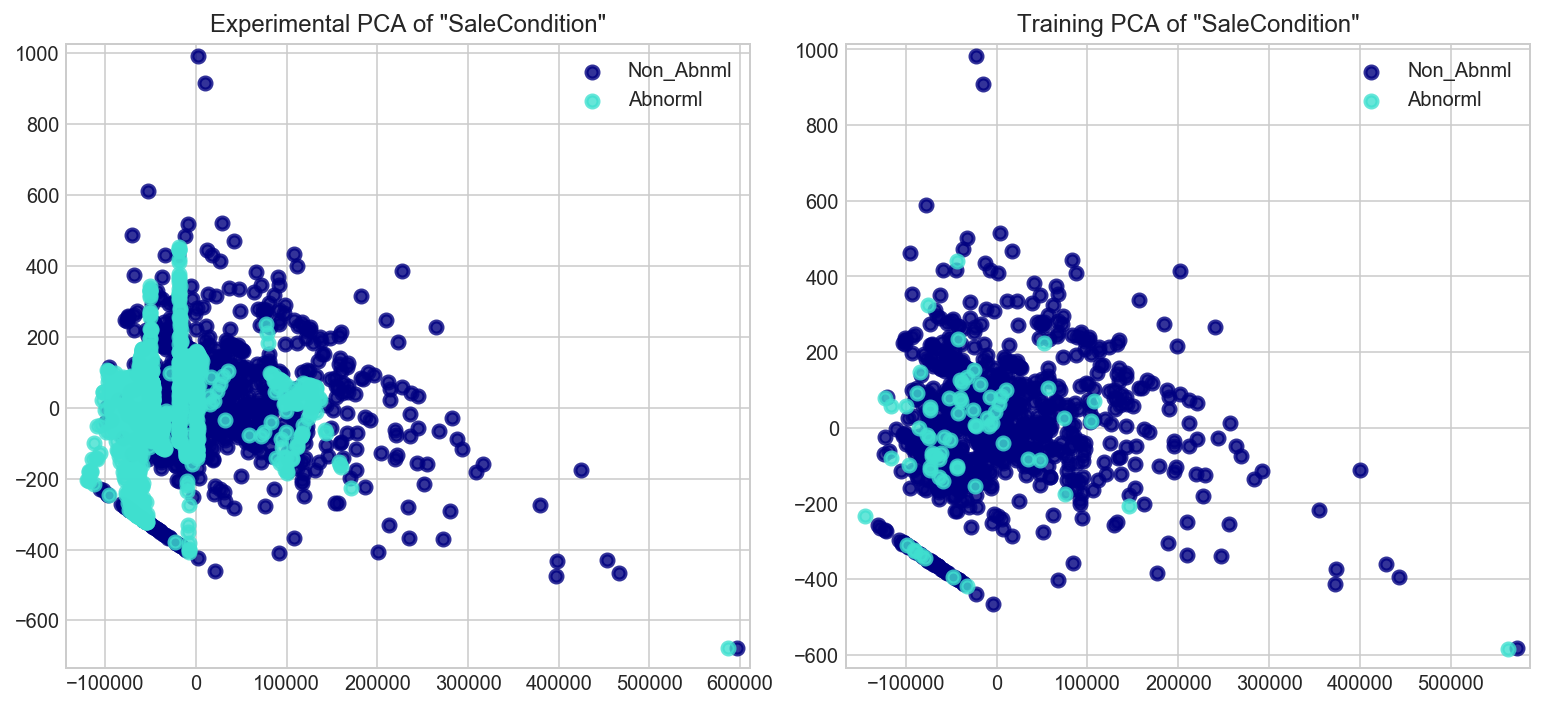

In [12]:
### Experimental Segment, PCA visualisation ###
# Experimental segment of the various sampling methods to achieve a more distinct PCA clustering pattern
# compared to the original training data

# Define pipeline for sampling
pipeline2 = Pipeline([('smt', smt)])
X_expt, y_expt = pipeline2.fit_sample(X_train, y_train)

pca_expt = PCA(n_components=2)
X_r_expt = pca_expt.fit_transform(X_expt)

# Percentage of variance explained for each components
print('explained variance ratio (first two components), experimental: %s'
      % str(pca_expt.explained_variance_ratio_))

plt.figure(figsize=(11,5)); plt.subplot(1, 2, 1)
colors = ['navy', 'turquoise']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r_expt[y_expt == i, 0], X_r_expt[y_expt == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Experimental PCA of "SaleCondition"')
plt.tight_layout(); plt.margins(0.02)

plt.subplot(1, 2, 2)
colors = ['navy', 'turquoise']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Training PCA of "SaleCondition"')
plt.tight_layout(); plt.margins(0.02)

plt.show()

Using SMOTE, the cluster patterns disappear completely and appear more chaotic. This was similarly observed in the other experimentations such as using a SVM variation of SMOTE. Even implementing a Tomek Link filter on both classes had minimal impact on the classification report.

Other over sampling methods offered in imblearn were poor for this dataset as well with SMOTE being the most chaotic or perhaps overfitting on the data. Although it could be tuned but it would have taken more effort to define the boundaries.

In an attempt to down sample the majority class, the repeated edited nearest neighbour(renn) 'under-sampler' was found to preserve the clustering pattern the best. All else were not as efficient as the renn method.

explained variance ratio (first two components), chosen: [  9.99996238e-01   3.25645308e-06]


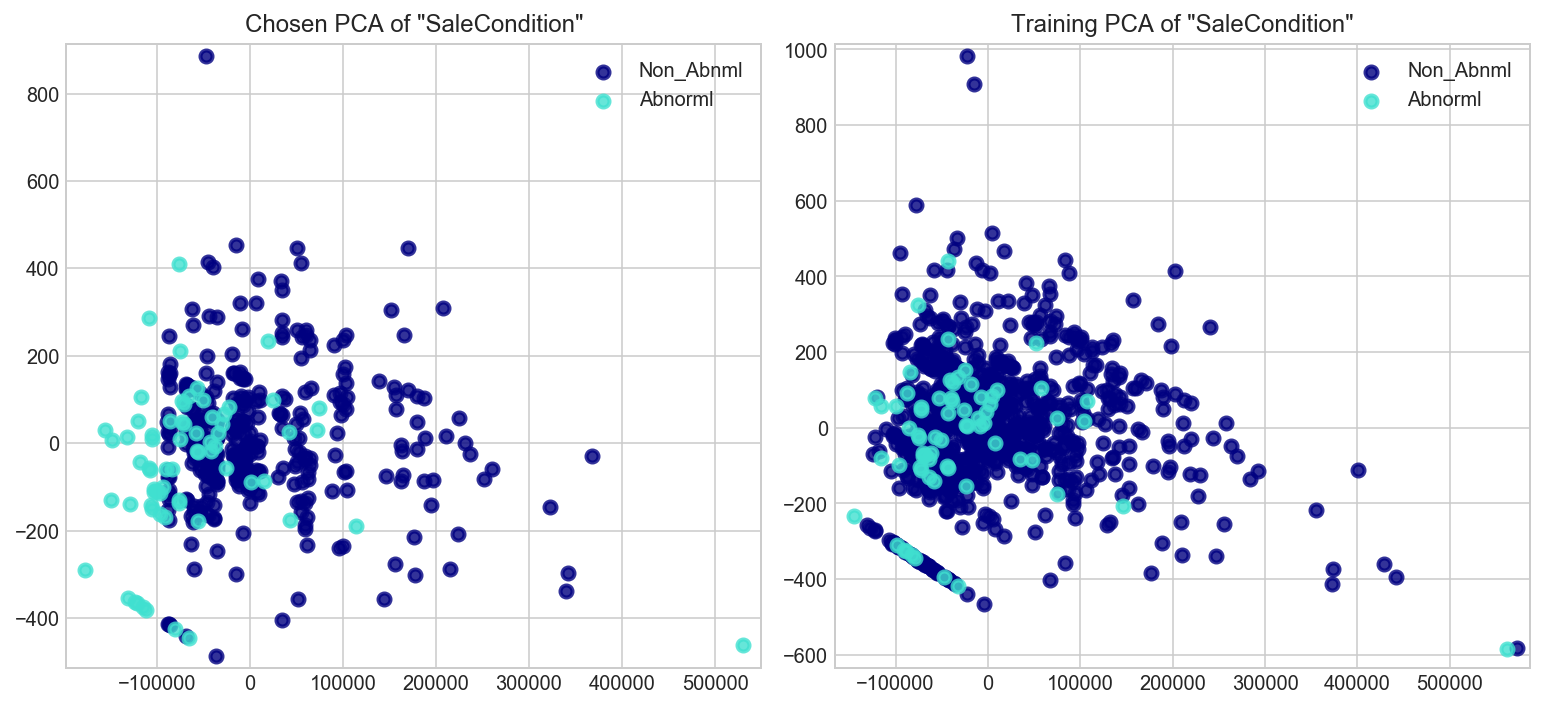

In [13]:
### Chosen Model, PCA visualisation ###

# Define pipeline for sampling
pipeline3 = Pipeline([('renn', renn), ('tl', tl)])
X_chosen, y_chosen = pipeline3.fit_sample(X_train, y_train)

pca_chosen = PCA(n_components=2)
X_r_chosen = pca_chosen.fit_transform(X_chosen)

# Percentage of variance explained for each components
print('explained variance ratio (first two components), chosen: %s'
      % str(pca_chosen.explained_variance_ratio_))

plt.figure(figsize=(11,5)); plt.subplot(1, 2, 1)
colors = ['navy', 'turquoise']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r_chosen[y_chosen == i, 0], X_r_chosen[y_chosen == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Chosen PCA of "SaleCondition"')
plt.tight_layout(); plt.margins(0.02)

# Training PCA
plt.subplot(1, 2, 2)
colors = ['navy', 'turquoise']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, alpha=.8, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Training PCA of "SaleCondition"')
plt.tight_layout(); plt.margins(0.02)

plt.show()

From above, the clustering pattern appears to mimic that of the original training set the best. Lower values of the hyperparameter max_iter of enn (to remove less of the majority class) would significantly reduce the recall on the minority which is not the aim of the intention stated above.

In [14]:
### Final Chosen Model ###

"""
[Chosen]
renn = RepeatedEditedNearestNeighbours(ratio='majority', n_neighbors=9, random_state=42, max_iter=666666)
tl = TomekLinks(ratio='all', random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_estimators=600, ratio='all', replacement=True, oob_score=False, n_jobs=-1)
pipeline = Pipeline([('renn', renn), ('tl', tl), ('bbc', bbc)])

[Noteworthy Experimental Results]
****************************************************************************************************************************
renn = RepeatedEditedNearestNeighbours(ratio='majority', n_neighbors=9, random_state=42, max_iter=888888)
bbc = BalancedBaggingClassifier(random_state=42, n_estimators=750, ratio='auto', replacement=False, oob_score=False, n_jobs=-1)
pipeline = Pipeline([('renn', renn), ('bbc', bbc)])

Confusion Matrix:  
 [[242 165]
 [  9  19]]
Classification Report 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.59      0.68      0.74      0.32      0.11       407
          1       0.10      0.68      0.59      0.18      0.32      0.09        28

avg / total       0.91      0.60      0.67      0.70      0.32      0.11       435

****************************************************************************************************************************
smotetl = SMOTETomek(random_state=42, tomek=tl, smote=smt)
bbc = BalancedBaggingClassifier(random_state=42, n_estimators=600, ratio='all', replacement=True, oob_score=False, n_jobs=-1)
pipeline = Pipeline([('smotetl', smotetl), ('bbc', bbc)])

Confusion Matrix:  
 [[394  13]
 [ 21   7]]
Classification Report 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.97      0.25      0.96      0.58      0.35       407
          1       0.35      0.25      0.97      0.29      0.58      0.31        28

avg / total       0.91      0.92      0.30      0.92      0.58      0.35       435

****************************************************************************************************************************
"""

# Pipeline sampling methods and perform classification/prediction
pipeline = Pipeline([('renn', renn), ('tl', tl), ('bbc', bbc)])
pipeline.fit(X_train, y_train)
y_hat = pipeline.predict(X_test)

print('Confusion Matrix: ', '\n', confusion_matrix(y_test, y_hat))
print('Classification Report', '\n', classification_report_imbalanced(y_test, y_hat))

Confusion Matrix:  
 [[263 144]
 [  9  19]]
Classification Report 
                    pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.65      0.68      0.77      0.34      0.12       407
          1       0.12      0.68      0.65      0.20      0.34      0.10        28

avg / total       0.91      0.65      0.68      0.74      0.34      0.12       435



#### Result Conclusion

It is a balancing act between up-sampling the minority class while down-sampling the majority. Whichever class that ends up as the dominant class would have a high recall / low precision while the other class would have poorer recall but precision appears to be high.

The aim was to raise the recall of the minority class as far as possible without compromising the recall on the original majority class by too much. For this particular dataset, best efforts for recall ranges around 0.6 to 0.7 for both classes, abnormal/normal.

A grid search may be implemented to improve the tuning portion of the hyperparameters or other more sophisticated pipelining of upsampling/downsampling methods, as well as the kind of classifier, could be explored.